In [43]:
#Fausto Vega
using ECOS, Convex, LinearAlgebra
using SatelliteDynamics
using COSMO
using Mosek
using MosekTools

In [44]:
function skewmatrix(x)
    S = [0 -x[3] x[2]; x[3] 0 -x[1]; -x[2] x[1] 0]
    return S
end

skewmatrix (generic function with 1 method)

In [45]:
α = 5e-4 #mass depletion constant

0.0005

In [1]:
#For MARS 
#omega for mars
omega = [2.53e-5 0 6.62e-5]

#mars gravity
g = vec([-3.71 0 0])

3-element Vector{Float64}:
 -3.71
  0.0
  0.0

In [47]:
nx = 7 #number of states [position velocity mass]
nu = 4 #number of controls on acceleration
nd = 7 #number of affine variables

7

In [48]:
#number of knot points
N = 48

48

In [50]:
dt = 1 #time step

1

In [51]:
#Create A Matrix
A = [zeros(3,3) I zeros(3); -(skewmatrix(omega))^2 -2*skewmatrix(omega) zeros(3); zeros(7)']

#Create B Matrix

B_original = [zeros(3,3); I]

B = [B_original zeros(6);zeros(3)' -α]

#Affine term
d = [zeros(3,3); I; zeros(3)']*g

#Create Ã
Ã = [A B I; zeros(nu,nx+nu+nd); zeros(nd,nx+nu+nd)]

18×18 Matrix{Float64}:
  0.0          0.0          0.0         …  1.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          0.0          0.0            0.0  1.0  0.0  0.0  0.0  0.0  0.0
  0.0          0.0          0.0            0.0  0.0  1.0  0.0  0.0  0.0  0.0
  4.38244e-9  -0.0         -1.67486e-9     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 -0.0          5.02253e-9  -0.0            0.0  0.0  0.0  0.0  1.0  0.0  0.0
 -1.67486e-9  -0.0          6.4009e-10  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
  0.0          0.0          0.0            0.0  0.0  0.0  0.0  0.0  0.0  1.0
  0.0          0.0          0.0            0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          0.0          0.0            0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          0.0          0.0            0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          0.0          0.0         …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          0.0          0.0            0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          0.0          0.0            0.0  0.0  

In [52]:
#change from continous to discrete 
H = exp(dt*Ã) 

Ad = H[1:nx, 1:nx] 
Bd = H[1:nx,(nx+1):(nx+4)]
Dd = H[1:nx, (nx+5):end]

7×7 Matrix{Float64}:
  1.0           2.77076e-14  -2.79143e-10  …   2.20667e-5  2.09357e-10  0.0
 -2.77076e-14   1.0           1.05892e-14      0.5         8.43333e-6   0.0
 -2.79143e-10  -1.05892e-14   1.0             -8.43333e-6  0.5          0.0
  2.19122e-9    1.1083e-13   -8.3743e-10       6.62e-5     8.3743e-10   0.0
 -1.1083e-13    2.51126e-9    4.23567e-14      1.0         2.53e-5      0.0
 -8.3743e-10   -4.23567e-14   3.20045e-10  …  -2.53e-5     1.0          0.0
  0.0           0.0           0.0              0.0         0.0          1.0

In [2]:
mf = 300 #final mass kg (not used in optimization)
m0 = 2000 # initial mass kg

#Landing state
x_goal = [0, 0, 0, 0, 0, 0, log(mf)] #x,y,z, vx,vy,vz, z(mass variable)

#Initial state
x_initial = [2400, 450, -330, -10, -40, 10, log(m0)] #prob1

#x_initial = [2400, 3400, 0, -40, 45, 0, log(m0)] #prob2

7-element Vector{Float64}:
 2400.0
  450.0
 -330.0
  -10.0
  -40.0
   10.0
    7.600902459542082

In [54]:
theta = 70*pi/180 #Thrust pointing angle
Vmax = 90 #Maximum velocity
gs = pi/6 #Glideslop angle
maxthrust = 24000
Tmin = 0.2* maxthrust #maximum thrust
Tmax = 0.8* maxthrust #minimum thrust

#mass dynamics values
z0 = zeros(N)

for k in 1:N
    z0[k] = log(m0 - α*Tmax*(k-1))
end

In [55]:
#update problem 1 solution
function update_prob1(x_initial, N)
    
    cons1 = 0
    X1 = 0
    U1 = 0
    
    X1 = Variable(nx, N)
    U1 = Variable(nu, N-1)
    
    c = ([1 0 0]')/tan(gs)

    cons1 = Constraint[X1[:,1] == x_initial]

    n = vec([1 0 0]) #vector pointing up

    #state constraints
    #Dynamics Constraint
    for k=1:(N-1)
        push!(cons1, X1[:,k+1] == Ad*X1[:,k]+Bd*U1[:,k]+Dd*d)

    end

    #Velocity Constraint: To avoid supersonic
    for k=1:N
        push!(cons1, norm(X1[4:6, k]) <= Vmax)

        #Glideslope constraint

        push!(cons1, norm(X1[2:3, k] - X1[2:3, N]) - c'*(X1[1:3,k] - X1[1:3,N]) <= 0)  
    end

    #Goal constraint

    push!(cons1, X1[4:6, N] == 0) #final velocity has to be zero
    #push!(cons, X[1:3,N] == 0) #final position has to be at zero after the sim works!

    push!(cons1, X1[1, N] == 0)

    #Controls Constraints
    for k=1:(N-1)

        σ1 = U1[4,k]

        push!(cons1, norm(U1[1:3,k])<= σ1)

        #thrust vector inside a cone
        push!(cons1, n'*U1[1:3,k] >= σ1*cos(theta))

        #push!(cons, Tmin*exp(-z0[k])*(1-(z[k] - z0[k]) + 0.5*(z[k] - z0[k])*(z[k] - z0[k])) <= σ[k])
        #push!(cons, Tmin*exp(-z0[k])*(1-(X[7,k] - z0[k])) <= σ) #First order taylor expansion
        push!(cons1, Tmin*exp(-z0[k])*(1-(X1[7,k] - z0[k]) + (square((X1[7,k] - z0[k]))/2)) <= σ1) #second ordre taylor expansion
        push!(cons1, σ1 <= Tmax*exp(-z0[k])*(1 - (X1[7,k] - z0[k])))

    end
   
    return cons1, X1, U1
end

update_prob1 (generic function with 1 method)

In [56]:
#Create optimization problem 
function solve_prob1(cons1, X1, U1)
    
    prob1 = minimize(norm(X1[2:3,N] - x_goal[2:3]), cons1) #solve landing error minimization problem

    #Solve problem
    solve!(prob1, ()-> Mosek.Optimizer())
    
    Xm1 = X1.value; 
    Um1 = U1.value; 
    
    return Xm1, Um1
end

solve_prob1 (generic function with 1 method)

In [57]:
#update fuel optimization problem
function update_prob2(x_initial, N, Xm1)
    #create second optimization problem

    cons2 = 0
    X2 = 0
    U2 = 0
    
    X2 = Variable(nx, N)
    U2 = Variable(nu, N-1)


    c2 = ([1 0 0]')/tan(gs)

    cons2 = Constraint[X2[:,1] == x_initial]

    n2 = vec([1 0 0]) #vector pointing up

    #state constraints
    #Dynamics Constraint
    for k=1:(N-1)
        push!(cons2, X2[:,k+1] == Ad*X2[:,k]+Bd*U2[:,k]+Dd*d)

    end

    #Velocity Constraint: To avoid supersonic
    for k=1:N
        push!(cons2, norm(X2[4:6, k]) <= Vmax)

        #Glideslope constraint

        push!(cons2, norm(X2[2:3, k] - X2[2:3, N]) - c2'*(X2[1:3,k] - X2[1:3,N]) <= 0)  
    end

    #Goal constraint

    push!(cons2, X2[4:6, N] == 0) #final velocity has to be zer

    push!(cons2, X2[1,N] == 0)

    push!(cons2, norm(X2[2:3,N]-x_goal[2:3]) <= norm(Xm1[2:3,N] - x_goal[2:3]))

    #Controls Constraints
    for k=1:(N-1)

        σ2 = U2[4,k]

        push!(cons2, norm(U2[1:3,k])<= σ2)

        #thrust vector inside a cone
        push!(cons2, n2'*U2[1:3,k] >= σ2*cos(theta))

        #push!(cons2, Tmin*exp(-z0[k])*(1-(X2[7,k] - z0[k])) <= σ2) #first order taylor expansion

        push!(cons2, Tmin*exp(-z0[k])*(1-(X2[7,k] - z0[k]) + (square((X2[7,k] - z0[k]))/2)) <= σ2) #second order taylor expansion

        push!(cons2, σ2 <= Tmax*exp(-z0[k])*(1 - (X2[7,k] - z0[k])))

    end
    
    return cons2, X2, U2
end

update_prob2 (generic function with 1 method)

In [58]:
#solve fuel optimization problem
function solve_prob2(cons2, X2, U2)
    
    prob2 = minimize(sum(abs(U2[4,:])), cons2)
    #Solve problem
    solve!(prob2, ()-> Mosek.Optimizer())
    
    Xm2 = X2.value; 
    Um2 = U2.value; 
    
    return Xm2, Um2
    
end

solve_prob2 (generic function with 1 method)

In [59]:
total_N = 48 #number of knot points
N = 48 #number of knot points

iters_left = 15

optimal_x = zeros(nx, N)
optimal_u = zeros(nu, N-1)

#initial state
x_initial = [2400, 450, -330, -10, -40, 10, log(m0)] 

for i = 1:N-iters_left+1
    
    cons1, X1, U1 = update_prob1(x_initial, N)
    
    Xm1, Um1 = solve_prob1(cons1, X1, U1)
    
    cons2, X2, U2 = update_prob2(x_initial, N, Xm1)
    
    Xm2, Um2 = solve_prob2(cons2, X2, U2)
    
    optimal_x[:,i] = Xm2[:,1]
    
    optimal_u[:,i] = Um2[:,1]
    
    noise_pose = randn(3)*0
    noise_velocity = randn(3)*0.1
    state_noise = vec([noise_pose' noise_velocity' 0])' #noise on velocities
    
    x_initial .= Ad*Xm2[:,1]+Bd*Um2[:,1]+Dd*d + state_noise' #execute the first control action
    
    println("N: ", N)
    
    N = N-1
    
    #Fill in the remaining of the trajectory
    if i == total_N-iters_left+1
        

            optimal_x[:,total_N - N + k] = Xm2[:,k]
    
            if k != N 
                optimal_u[:,total_N - N + k] = Um2[:,k]
            end
    
        end
        
    end
    
end

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name    

8   2.8e+00  2.4e+00  1.7e+01  8.81e-01   1.017772471e+03   5.101306582e+02   1.2e-03  0.08  
9   2.3e+00  2.0e+00  1.4e+01  7.39e-01   1.087256174e+03   6.295325011e+02   9.6e-04  0.08  
10  1.6e+00  1.4e+00  1.0e+01  5.78e-01   1.125659899e+03   7.322860602e+02   6.8e-04  0.09  
11  8.7e-01  7.5e-01  4.3e+00  5.63e-01   7.993631383e+02   5.607257138e+02   3.6e-04  0.10  
12  2.8e-01  2.4e-01  8.5e-01  7.44e-01   4.201625742e+02   3.355311364e+02   1.2e-04  0.10  
13  9.2e-02  7.8e-02  1.4e-01  1.05e+00   2.942652603e+02   2.689279258e+02   3.8e-05  0.11  
14  4.8e-02  4.1e-02  5.4e-02  1.14e+00   2.604913965e+02   2.477457372e+02   2.0e-05  0.11  
15  2.8e-02  2.4e-02  2.4e-02  1.07e+00   2.432060245e+02   2.358689013e+02   1.2e-05  0.12  
16  1.5e-02  1.3e-02  9.9e-03  1.03e+00   2.311378096e+02   2.271787997e+02   6.4e-06  0.13  
17  8.0e-03  6.9e-03  3.8e-03  1.02e+00   2.242601187e+02   2.222030332e+02   3.4e-06  0.13  
18  3.6e-03  3.1e-03  1.1e-03  1.02e+00   2.199906929e+02   

8   2.7e+00  2.3e+00  1.6e+01  8.67e-01   9.189888013e+02   4.444088181e+02   1.1e-03  0.07  
9   2.2e+00  1.9e+00  1.3e+01  7.43e-01   1.000817712e+03   5.667844978e+02   9.4e-04  0.08  
10  1.6e+00  1.4e+00  9.6e+00  5.77e-01   1.052144770e+03   6.692014765e+02   6.9e-04  0.08  
11  7.6e-01  6.6e-01  3.5e+00  5.59e-01   6.998040822e+02   4.928317421e+02   3.2e-04  0.09  
12  2.8e-01  2.4e-01  8.0e-01  7.87e-01   3.992027332e+02   3.185285205e+02   1.2e-04  0.09  
13  8.6e-02  7.4e-02  1.3e-01  1.05e+00   2.846543435e+02   2.618339366e+02   3.6e-05  0.10  
14  4.3e-02  3.7e-02  4.4e-02  1.13e+00   2.527946062e+02   2.418981455e+02   1.8e-05  0.10  
15  2.6e-02  2.2e-02  2.1e-02  1.05e+00   2.378002268e+02   2.312371945e+02   1.1e-05  0.10  
16  1.4e-02  1.2e-02  8.3e-03  1.04e+00   2.268741962e+02   2.234255291e+02   5.9e-06  0.11  
17  7.0e-03  6.1e-03  3.0e-03  1.02e+00   2.206264360e+02   2.188956492e+02   3.0e-06  0.11  
18  3.6e-03  3.1e-03  1.1e-03  1.01e+00   2.173601618e+02   

6   1.6e+01  1.4e+01  1.7e+02  -2.55e-01  3.185568904e+03   1.181572728e+03   6.9e-03  0.07  
7   4.0e+00  3.4e+00  2.7e+01  2.03e-01   1.270933483e+03   5.975823892e+02   1.7e-03  0.08  
8   2.5e+00  2.2e+00  1.4e+01  8.36e-01   8.027595454e+02   3.655530417e+02   1.1e-03  0.09  
9   2.1e+00  1.9e+00  1.2e+01  7.46e-01   8.953813570e+02   4.887446163e+02   9.1e-04  0.09  
10  1.6e+00  1.4e+00  9.3e+00  5.31e-01   9.696118599e+02   5.926075443e+02   6.9e-04  0.10  
11  6.5e-01  5.7e-01  2.7e+00  5.69e-01   6.017123166e+02   4.261856048e+02   2.8e-04  0.11  
12  2.4e-01  2.1e-01  5.9e-01  8.42e-01   3.548279179e+02   2.895370237e+02   1.0e-04  0.11  
13  7.2e-02  6.2e-02  9.1e-02  1.09e+00   2.672896757e+02   2.490776235e+02   3.0e-05  0.12  
14  3.8e-02  3.3e-02  3.5e-02  1.12e+00   2.443335483e+02   2.351139306e+02   1.6e-05  0.12  
15  2.3e-02  2.0e-02  1.7e-02  1.04e+00   2.313403804e+02   2.258081440e+02   9.7e-06  0.13  
16  1.3e-02  1.2e-02  7.4e-03  1.03e+00   2.231340715e+02   

12  2.1e-01  1.8e-01  4.7e-01  8.63e-01   3.327852995e+02   2.774122206e+02   9.0e-05  0.08  
13  6.5e-02  5.7e-02  7.7e-02  1.11e+00   2.589234714e+02   2.430872828e+02   2.8e-05  0.08  
14  3.5e-02  3.1e-02  3.1e-02  1.11e+00   2.389108834e+02   2.305505293e+02   1.5e-05  0.09  
15  2.1e-02  1.8e-02  1.4e-02  1.04e+00   2.265736452e+02   2.216522258e+02   9.0e-06  0.09  
16  1.1e-02  9.6e-03  5.4e-03  1.02e+00   2.184363256e+02   2.159040952e+02   4.7e-06  0.10  
17  5.6e-03  4.9e-03  2.0e-03  1.02e+00   2.140563720e+02   2.127608864e+02   2.4e-06  0.10  
18  2.4e-03  2.1e-03  5.6e-04  1.01e+00   2.112897860e+02   2.107392866e+02   1.0e-06  0.11  
19  8.2e-04  7.2e-04  1.1e-04  1.00e+00   2.098605034e+02   2.096721979e+02   3.5e-07  0.11  
20  2.5e-04  2.2e-04  1.9e-05  1.00e+00   2.093131049e+02   2.092557549e+02   1.1e-07  0.11  
21  6.6e-05  5.8e-05  2.6e-06  1.00e+00   2.091084721e+02   2.090934138e+02   2.8e-08  0.12  
22  4.0e-05  3.5e-05  1.2e-06  1.00e+00   2.090777781e+02   

9   2.0e+00  1.8e+00  9.9e+00  8.29e-01   7.466614244e+02   3.902758491e+02   8.7e-04  0.08  
10  1.5e+00  1.4e+00  7.8e+00  5.71e-01   8.453175904e+02   5.216544062e+02   6.6e-04  0.08  
11  7.0e-01  6.2e-01  2.7e+00  5.37e-01   5.690784037e+02   3.986679784e+02   3.0e-04  0.09  
12  1.9e-01  1.7e-01  3.8e-01  8.19e-01   3.135013632e+02   2.650946125e+02   8.2e-05  0.09  
13  6.2e-02  5.5e-02  6.9e-02  1.13e+00   2.520506118e+02   2.376231056e+02   2.7e-05  0.10  
14  3.6e-02  3.2e-02  3.2e-02  1.08e+00   2.352476180e+02   2.268483584e+02   1.6e-05  0.10  
15  2.1e-02  1.9e-02  1.4e-02  1.06e+00   2.233305092e+02   2.184926135e+02   9.2e-06  0.11  
16  1.2e-02  1.1e-02  6.4e-03  1.04e+00   2.162275259e+02   2.134420369e+02   5.4e-06  0.11  
17  5.3e-03  4.7e-03  1.8e-03  1.02e+00   2.108911526e+02   2.097065726e+02   2.3e-06  0.12  
18  1.8e-03  1.6e-03  3.6e-04  1.01e+00   2.081262445e+02   2.077219504e+02   7.9e-07  0.13  
19  7.8e-04  6.9e-04  1.0e-04  1.00e+00   2.072087750e+02   

14  4.9e-02  4.4e-02  4.8e-02  1.09e+00   2.397941118e+02   2.287351526e+02   2.1e-05  0.08  
15  2.3e-02  2.1e-02  1.6e-02  1.08e+00   2.223416895e+02   2.172453308e+02   1.0e-05  0.09  
16  1.5e-02  1.3e-02  7.9e-03  1.04e+00   2.151475340e+02   2.119475212e+02   6.4e-06  0.09  
17  6.7e-03  6.0e-03  2.5e-03  1.02e+00   2.093638055e+02   2.079103647e+02   2.9e-06  0.10  
18  2.6e-03  2.3e-03  5.8e-04  1.01e+00   2.061375920e+02   2.055875833e+02   1.1e-06  0.10  
19  1.0e-03  9.3e-04  1.5e-04  1.00e+00   2.048825765e+02   2.046607380e+02   4.5e-07  0.10  
20  4.4e-04  3.9e-04  4.2e-05  1.00e+00   2.043667784e+02   2.042732710e+02   1.9e-07  0.11  
21  1.4e-04  1.3e-04  7.7e-06  1.00e+00   2.040954955e+02   2.040652298e+02   6.2e-08  0.11  
22  3.2e-05  2.9e-05  8.5e-07  1.00e+00   2.039855748e+02   2.039786550e+02   1.4e-08  0.12  
23  6.8e-06  6.1e-06  8.2e-08  1.00e+00   2.039578014e+02   2.039563431e+02   3.0e-09  0.12  
24  3.0e-07  2.7e-07  7.5e-10  1.00e+00   2.039504541e+02   

8   2.6e+00  2.3e+00  1.3e+01  7.73e-01   6.923718754e+02   2.795524675e+02   1.1e-03  0.07  
9   2.1e+00  1.9e+00  9.6e+00  8.85e-01   6.481701922e+02   3.096937307e+02   9.2e-04  0.08  
10  1.7e+00  1.5e+00  8.0e+00  6.85e-01   7.335500784e+02   4.208838451e+02   7.5e-04  0.09  
11  1.1e+00  9.7e-01  4.8e+00  5.31e-01   6.624695065e+02   4.250259815e+02   4.8e-04  0.09  
12  3.7e-01  3.4e-01  1.0e+00  7.35e-01   3.799248823e+02   2.897769523e+02   1.7e-04  0.09  
13  1.0e-01  9.4e-02  1.5e-01  1.02e+00   2.702152864e+02   2.467344539e+02   4.6e-05  0.10  
14  4.4e-02  4.0e-02  4.0e-02  1.13e+00   2.344295059e+02   2.249446352e+02   2.0e-05  0.10  
15  2.6e-02  2.3e-02  1.7e-02  1.03e+00   2.203673017e+02   2.149862122e+02   1.1e-05  0.11  
16  1.3e-02  1.2e-02  6.5e-03  1.03e+00   2.112614966e+02   2.085133235e+02   5.8e-06  0.12  
17  5.8e-03  5.2e-03  1.9e-03  1.02e+00   2.059817435e+02   2.047822124e+02   2.6e-06  0.12  
18  2.1e-03  1.9e-03  4.2e-04  1.01e+00   2.032267570e+02   

15  2.4e-02  2.2e-02  1.5e-02  1.02e+00   2.160575734e+02   2.112540090e+02   1.1e-05  0.09  
16  1.2e-02  1.1e-02  5.3e-03  1.02e+00   2.076875438e+02   2.053296509e+02   5.2e-06  0.09  
17  5.2e-03  4.8e-03  1.6e-03  1.01e+00   2.030460028e+02   2.019959052e+02   2.3e-06  0.10  
18  1.9e-03  1.8e-03  3.7e-04  1.01e+00   2.005884054e+02   2.001992390e+02   8.7e-07  0.10  
19  7.0e-04  6.4e-04  8.0e-05  1.00e+00   1.996216806e+02   1.994813689e+02   3.1e-07  0.11  
20  2.1e-04  2.0e-04  1.4e-05  1.00e+00   1.992181642e+02   1.991754533e+02   9.6e-08  0.11  
21  7.4e-05  6.8e-05  2.8e-06  1.00e+00   1.990953989e+02   1.990806618e+02   3.3e-08  0.11  
22  3.6e-05  3.3e-05  9.5e-07  1.00e+00   1.990603050e+02   1.990530779e+02   1.6e-08  0.12  
23  5.4e-06  4.9e-06  5.4e-08  1.00e+00   1.990310239e+02   1.990299543e+02   2.4e-09  0.12  
24  9.4e-08  8.6e-08  1.3e-10  1.00e+00   1.990257955e+02   1.990257767e+02   4.2e-11  0.12  
25  4.4e-09  2.2e-09  5.0e-13  1.00e+00   1.990257015e+02   

8   2.3e+00  2.2e+00  1.1e+01  8.11e-01   6.122684285e+02   2.541193309e+02   1.1e-03  0.08  
9   1.8e+00  1.7e+00  8.0e+00  9.02e-01   5.742388374e+02   2.828114062e+02   8.4e-04  0.09  
10  1.5e+00  1.4e+00  6.7e+00  6.96e-01   6.549955384e+02   3.834038147e+02   6.9e-04  0.09  
11  9.2e-01  8.6e-01  3.7e+00  5.77e-01   5.427078289e+02   3.515036475e+02   4.2e-04  0.10  
12  3.3e-01  3.1e-01  8.2e-01  7.93e-01   3.357285099e+02   2.625037313e+02   1.5e-04  0.10  
13  9.0e-02  8.4e-02  1.1e-01  1.04e+00   2.540135454e+02   2.354828335e+02   4.1e-05  0.11  
14  3.8e-02  3.6e-02  3.1e-02  1.10e+00   2.233967855e+02   2.158498014e+02   1.7e-05  0.11  
15  2.2e-02  2.1e-02  1.4e-02  1.02e+00   2.120588853e+02   2.076942886e+02   1.0e-05  0.12  
16  1.1e-02  9.9e-03  4.5e-03  1.02e+00   2.042459017e+02   2.021867313e+02   4.8e-06  0.12  
17  5.0e-03  4.7e-03  1.5e-03  1.01e+00   2.003643754e+02   1.993935873e+02   2.3e-06  0.13  
18  1.9e-03  1.8e-03  3.5e-04  1.00e+00   1.981273675e+02   

12  2.7e-01  2.6e-01  6.0e-01  7.97e-01   3.022526628e+02   2.438086703e+02   1.3e-04  0.08  
13  1.1e-01  1.0e-01  1.5e-01  1.08e+00   2.439199129e+02   2.220225205e+02   5.1e-05  0.08  
14  8.6e-02  8.2e-02  1.0e-01  1.06e+00   2.363103252e+02   2.190914604e+02   4.0e-05  0.09  
15  3.3e-02  3.1e-02  2.5e-02  1.07e+00   2.142207690e+02   2.078180151e+02   1.5e-05  0.09  
16  2.0e-02  1.9e-02  1.2e-02  1.04e+00   2.063335273e+02   2.025179938e+02   9.2e-06  0.10  
17  9.4e-03  8.9e-03  3.7e-03  1.03e+00   2.002810459e+02   1.984988893e+02   4.4e-06  0.10  
18  4.3e-03  4.0e-03  1.1e-03  1.02e+00   1.971299294e+02   1.963285829e+02   2.0e-06  0.11  
19  1.5e-03  1.4e-03  2.4e-04  1.01e+00   1.953230450e+02   1.950422937e+02   6.9e-07  0.11  
20  6.1e-04  5.8e-04  6.2e-05  1.00e+00   1.947309937e+02   1.946172335e+02   2.8e-07  0.11  
21  2.0e-04  1.9e-04  1.1e-05  1.00e+00   1.944335630e+02   1.943968334e+02   9.1e-08  0.12  
22  1.0e-04  9.6e-05  4.2e-06  1.00e+00   1.943610090e+02   

10  1.7e+00  1.6e+00  7.1e+00  8.31e-01   5.330099024e+02   2.693877782e+02   7.8e-04  0.08  
11  1.2e+00  1.2e+00  5.0e+00  6.84e-01   5.391583297e+02   3.186472605e+02   5.7e-04  0.09  
12  4.7e-01  4.5e-01  1.3e+00  6.74e-01   3.511624454e+02   2.565723001e+02   2.2e-04  0.09  
13  1.2e-01  1.2e-01  1.7e-01  9.57e-01   2.417709404e+02   2.170406734e+02   5.9e-05  0.10  
14  5.7e-02  5.5e-02  5.3e-02  1.13e+00   2.197998995e+02   2.089954316e+02   2.7e-05  0.11  
15  3.3e-02  3.2e-02  2.3e-02  1.03e+00   2.088007549e+02   2.026931218e+02   1.5e-05  0.11  
16  1.8e-02  1.8e-02  9.8e-03  1.03e+00   2.018871274e+02   1.984875712e+02   8.7e-06  0.12  
17  1.0e-02  9.8e-03  4.0e-03  1.02e+00   1.976299126e+02   1.957780615e+02   4.8e-06  0.13  
18  4.9e-03  4.7e-03  1.3e-03  1.01e+00   1.948252506e+02   1.939376727e+02   2.3e-06  0.13  
19  2.1e-03  2.0e-03  3.7e-04  1.01e+00   1.931780533e+02   1.928051010e+02   9.7e-07  0.14  
20  1.0e-03  9.6e-04  1.3e-04  1.00e+00   1.925333193e+02   

12  4.4e-01  4.3e-01  1.2e+00  6.94e-01   3.321423143e+02   2.467497405e+02   2.1e-04  0.08  
13  1.2e-01  1.2e-01  1.5e-01  9.70e-01   2.353751738e+02   2.126331765e+02   5.8e-05  0.08  
14  6.7e-02  6.6e-02  6.6e-02  1.11e+00   2.198981702e+02   2.075279869e+02   3.2e-05  0.09  
15  3.4e-02  3.3e-02  2.3e-02  1.04e+00   2.063301753e+02   2.002514873e+02   1.6e-05  0.09  
16  2.0e-02  2.0e-02  1.1e-02  1.04e+00   1.997802132e+02   1.961514996e+02   9.8e-06  0.10  
17  1.1e-02  1.0e-02  4.2e-03  1.02e+00   1.951141492e+02   1.932293415e+02   5.1e-06  0.10  
18  4.6e-03  4.6e-03  1.2e-03  1.01e+00   1.921023108e+02   1.912874763e+02   2.2e-06  0.11  
19  2.3e-03  2.2e-03  4.2e-04  1.01e+00   1.908365954e+02   1.904362059e+02   1.1e-06  0.11  
20  8.4e-04  8.3e-04  9.5e-05  1.00e+00   1.900146896e+02   1.898674702e+02   4.0e-07  0.12  
21  2.9e-04  2.8e-04  1.9e-05  1.00e+00   1.896801043e+02   1.896299186e+02   1.4e-07  0.12  
22  1.2e-04  1.2e-04  5.2e-06  1.00e+00   1.895733522e+02   

17  1.0e-02  1.0e-02  3.8e-03  1.02e+00   1.918525841e+02   1.901292717e+02   4.9e-06  0.11  
18  4.0e-03  4.0e-03  9.4e-04  1.01e+00   1.890245659e+02   1.883491865e+02   1.9e-06  0.11  
19  1.3e-03  1.3e-03  1.8e-04  1.01e+00   1.876712481e+02   1.874526799e+02   6.3e-07  0.12  
20  5.5e-04  5.6e-04  5.0e-05  1.00e+00   1.872628676e+02   1.871691758e+02   2.7e-07  0.12  
21  2.1e-04  2.2e-04  1.2e-05  1.00e+00   1.870696835e+02   1.870331114e+02   1.1e-07  0.13  
22  1.3e-04  1.3e-04  5.5e-06  1.00e+00   1.870148706e+02   1.869933781e+02   6.2e-08  0.13  
23  2.3e-05  2.3e-05  4.2e-07  1.00e+00   1.869510462e+02   1.869471825e+02   1.1e-08  0.14  
24  4.4e-06  4.4e-06  3.6e-08  1.00e+00   1.869386804e+02   1.869379354e+02   2.2e-09  0.15  
25  3.0e-07  3.0e-07  6.4e-10  1.00e+00   1.869358413e+02   1.869357907e+02   1.5e-10  0.15  
26  4.5e-09  4.5e-09  1.2e-12  1.00e+00   1.869356343e+02   1.869356335e+02   2.2e-12  0.16  
Optimizer terminated. Time: 0.16    

N: 36
MOSEK warning 70

18  1.5e-03  1.6e-03  2.2e-04  1.00e+00   1.852315613e+02   1.849821034e+02   7.6e-07  0.09  
19  2.6e-04  2.7e-04  1.6e-05  1.00e+00   1.846106282e+02   1.845671835e+02   1.3e-07  0.09  
20  1.6e-04  1.7e-04  7.8e-06  1.00e+00   1.845496729e+02   1.845231681e+02   8.1e-08  0.10  
21  4.3e-05  4.5e-05  1.1e-06  1.00e+00   1.844801698e+02   1.844730675e+02   2.2e-08  0.10  
22  1.6e-05  1.7e-05  2.5e-07  1.00e+00   1.844630559e+02   1.844603926e+02   8.2e-09  0.10  
23  1.5e-06  1.5e-06  6.8e-09  1.00e+00   1.844537590e+02   1.844535192e+02   7.4e-10  0.11  
24  1.3e-07  1.3e-07  1.8e-10  1.00e+00   1.844528890e+02   1.844528676e+02   6.6e-11  0.11  
25  6.1e-09  4.3e-09  1.0e-12  1.00e+00   1.844528061e+02   1.844528055e+02   2.1e-12  0.12  
Optimizer terminated. Time: 0.12    

N: 35
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 

18  1.2e-03  1.2e-03  1.5e-04  1.00e+00   1.825883907e+02   1.824027638e+02   6.0e-07  0.10  
19  3.1e-04  3.3e-04  2.0e-05  1.00e+00   1.821709720e+02   1.821219170e+02   1.6e-07  0.11  
20  1.4e-04  1.5e-04  5.9e-06  1.00e+00   1.820835398e+02   1.820617419e+02   7.1e-08  0.11  
21  3.4e-05  3.6e-05  7.5e-07  1.00e+00   1.820297112e+02   1.820242519e+02   1.8e-08  0.12  
22  1.3e-05  1.4e-05  1.7e-07  1.00e+00   1.820178736e+02   1.820158199e+02   6.7e-09  0.12  
23  1.7e-06  1.8e-06  8.5e-09  1.00e+00   1.820115403e+02   1.820112657e+02   8.9e-10  0.12  
24  3.7e-08  4.0e-08  2.7e-11  1.00e+00   1.820105431e+02   1.820105371e+02   1.9e-11  0.13  
25  8.3e-09  2.2e-09  3.7e-13  1.00e+00   1.820105221e+02   1.820105217e+02   1.1e-12  0.13  
Optimizer terminated. Time: 0.14    

N: 34
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 

19  6.9e-04  7.5e-04  6.5e-05  1.00e+00   1.798884057e+02   1.797819303e+02   3.7e-07  0.09  
20  2.1e-04  2.3e-04  1.1e-05  1.00e+00   1.796764859e+02   1.796440648e+02   1.1e-07  0.09  
21  9.1e-05  9.9e-05  3.2e-06  1.00e+00   1.796190646e+02   1.796050178e+02   4.9e-08  0.10  
22  1.3e-05  1.4e-05  1.7e-07  1.00e+00   1.795805187e+02   1.795785097e+02   6.9e-09  0.10  
23  2.5e-06  2.7e-06  1.4e-08  1.00e+00   1.795750347e+02   1.795746514e+02   1.3e-09  0.10  
24  4.8e-08  5.2e-08  3.9e-11  1.00e+00   1.795737401e+02   1.795737327e+02   2.5e-11  0.11  
25  2.4e-08  1.3e-09  1.5e-13  1.00e+00   1.795737143e+02   1.795737141e+02   6.4e-13  0.11  
Optimizer terminated. Time: 0.11    

N: 33
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning

16  1.4e-03  1.6e-03  1.8e-04  9.99e-01   1.777014332e+02   1.774940149e+02   7.6e-07  0.09  
17  4.8e-04  5.4e-04  3.7e-05  9.99e-01   1.773326284e+02   1.772609473e+02   2.6e-07  0.09  
18  1.9e-04  2.1e-04  9.2e-06  1.00e+00   1.772120681e+02   1.771837709e+02   1.0e-07  0.10  
19  7.9e-05  8.9e-05  2.5e-06  1.00e+00   1.771640635e+02   1.771521990e+02   4.4e-08  0.10  
20  2.0e-05  2.2e-05  3.1e-07  1.00e+00   1.771370884e+02   1.771341647e+02   1.1e-08  0.11  
21  5.7e-06  6.4e-06  4.9e-08  1.00e+00   1.771304858e+02   1.771296332e+02   3.1e-09  0.11  
22  4.8e-07  5.4e-07  1.2e-09  1.00e+00   1.771279512e+02   1.771278798e+02   2.6e-10  0.11  
23  2.7e-08  3.1e-08  1.6e-11  1.00e+00   1.771277272e+02   1.771277231e+02   1.5e-11  0.12  
24  4.0e-08  5.9e-10  4.4e-14  1.00e+00   1.771277138e+02   1.771277137e+02   2.9e-13  0.12  
Optimizer terminated. Time: 0.12    

N: 32
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 7

19  4.0e-05  4.7e-05  9.1e-07  1.00e+00   1.747000773e+02   1.746942328e+02   2.3e-08  0.08  
20  4.7e-06  5.4e-06  3.6e-08  1.00e+00   1.746850183e+02   1.746843418e+02   2.7e-09  0.09  
21  4.1e-07  4.8e-07  9.4e-10  1.00e+00   1.746831389e+02   1.746830790e+02   2.4e-10  0.09  
22  4.6e-09  5.3e-09  1.1e-12  1.00e+00   1.746829576e+02   1.746829570e+02   2.6e-12  0.10  
Optimizer terminated. Time: 0.10    

N: 31
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warn

14  5.6e-03  6.8e-03  1.4e-03  9.69e-01   1.741022206e+02   1.733160087e+02   3.3e-06  0.09  
15  1.8e-03  2.2e-03  2.6e-04  9.97e-01   1.728179398e+02   1.725656606e+02   1.1e-06  0.10  
16  4.7e-04  5.7e-04  3.5e-05  1.00e+00   1.723768965e+02   1.723103962e+02   2.8e-07  0.10  
17  9.9e-05  1.2e-04  3.4e-06  1.00e+00   1.722494569e+02   1.722355570e+02   5.8e-08  0.11  
18  1.6e-05  1.9e-05  2.2e-07  1.00e+00   1.722180399e+02   1.722158166e+02   9.3e-09  0.11  
19  3.1e-07  3.7e-07  6.0e-10  1.00e+00   1.722119880e+02   1.722119447e+02   1.8e-10  0.12  
20  3.0e-09  3.2e-09  4.7e-13  1.00e+00   1.722118667e+02   1.722118664e+02   1.6e-12  0.12  
Optimizer terminated. Time: 0.13    

N: 30
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning

19  3.1e-08  2.9e-09  3.8e-13  1.00e+00   1.697473832e+02   1.697473829e+02   1.4e-12  0.09  
Optimizer terminated. Time: 0.09    

N: 29
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK w

17  2.2e-05  2.9e-05  3.6e-07  1.00e+00   1.672903780e+02   1.672874337e+02   1.4e-08  0.09  
18  4.8e-06  6.4e-06  3.7e-08  1.00e+00   1.672853652e+02   1.672847222e+02   3.1e-09  0.09  
19  5.5e-07  7.2e-07  1.4e-09  1.00e+00   1.672840516e+02   1.672839785e+02   3.5e-10  0.10  
20  2.1e-08  2.7e-08  1.0e-11  1.00e+00   1.672838874e+02   1.672838847e+02   1.3e-11  0.10  
21  5.9e-08  6.9e-11  1.3e-15  1.00e+00   1.672838810e+02   1.672838810e+02   3.4e-14  0.11  
Optimizer terminated. Time: 0.11    

N: 28
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warni

21  1.3e-08  1.0e-08  2.1e-12  1.00e+00   1.648165145e+02   1.648165136e+02   4.9e-12  0.09  
Optimizer terminated. Time: 0.09    

N: 27
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK w

N: 26
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Na

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name    

N: 24
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Na

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name    

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name    

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name    

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name    

Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 15
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 444             
  Cones                  : 63              
  Scalar variables       : 456             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 6               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 207
Optimizer  - Cones           

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(37) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(38) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(39) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(40) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(41) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(43) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(44) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(45) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(46) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

In [63]:
println(optimal_x[:,end])

[3.4598105492457227, 0.0478388759788606, -0.09792467477595981, -6.919618989432108, -0.09583209659056441, 0.1958485423408697, 7.498092547363422]


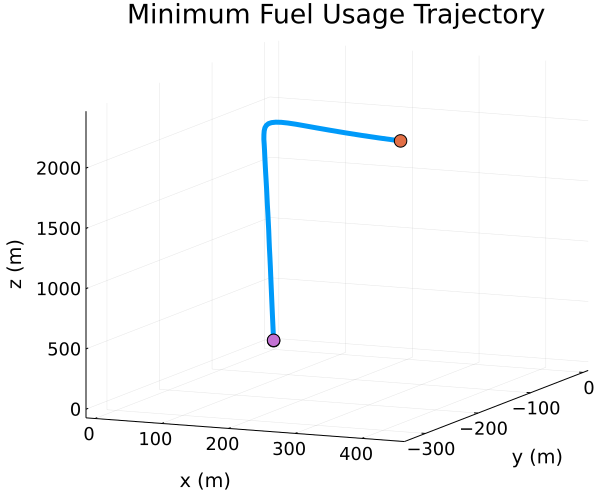

In [76]:
using Plots

Plots.plot(optimal_x[2,:],optimal_x[3,:],optimal_x[1,:], title="Minimum Fuel Usage Trajectory",xaxis="x (m)", yaxis="y (m)",zaxis="z (m)", legend=false, 
xtickfontsize=12,ytickfontsize=12,ztickfontsize=12, legendfont=font(15), guidefont=font(13), titlefont = font(18), linewidth=5)
Plots.scatter!([optimal_x[2,1]],[optimal_x[3,1]],[optimal_x[1,1]], markersize=7)
Plots.scatter!([x_goal[2]],[x_goal[3]],[x_goal[1]], label = ["xgoal"], markersize=7)
Plots.scatter!([last(optimal_x[2,:])],[last(optimal_x[3,:])],[last(optimal_x[1,:])], label = ["y"], markersize=7)

plot!(size=(600,500))

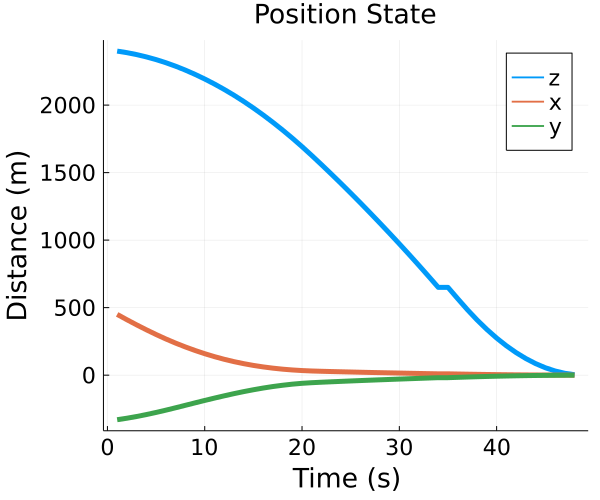

In [77]:
Plots.plot(optimal_x[1:3,:]',title="Position State",xaxis="Time (s)", yaxis="Distance (m)",zaxis="z (m)", legend=true, label = ["z" "x" "y"],
xtickfontsize=15,ytickfontsize=15, legendfont=font(15), guidefont=font(18), titlefont = font(18), linewidth=5)

plot!(size=(600,500))

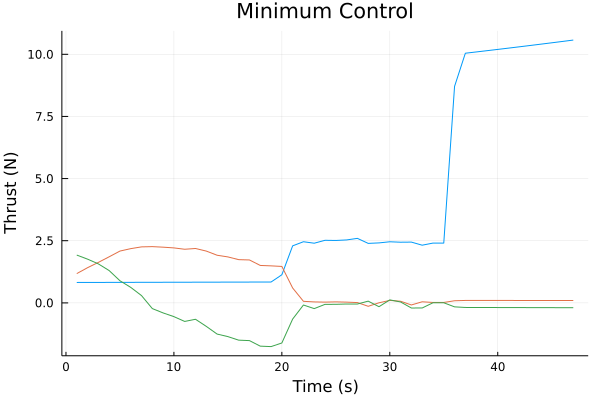

In [66]:
Plots.plot(optimal_u[1:3,:]',title="Minimum Control",xaxis="Time (s)", yaxis="Thrust (N)",zaxis="z (m)", legend=false)

In [67]:
xn = [norm(x) for x in eachcol(optimal_u[1:3,:])]

47-element Vector{Float64}:
  2.399983702955154
  2.402823780250185
  2.4057601769216888
  2.4086339139241093
  2.411525596203155
  2.4144605247117177
  2.417369534988555
  2.420313770447851
  2.423240590608913
  2.4261733129831295
  2.4291100318745804
  2.4320786733907283
  2.4350165261488312
  ⋮
  8.711360355045308
 10.046599145124283
 10.09713444225862
 10.148179536499788
 10.1997421685648
 10.25183023601936
 10.304451797392515
 10.357615076302903
 10.411328466210557
 10.465600534066388
 10.520440026246195
 10.57585587140689

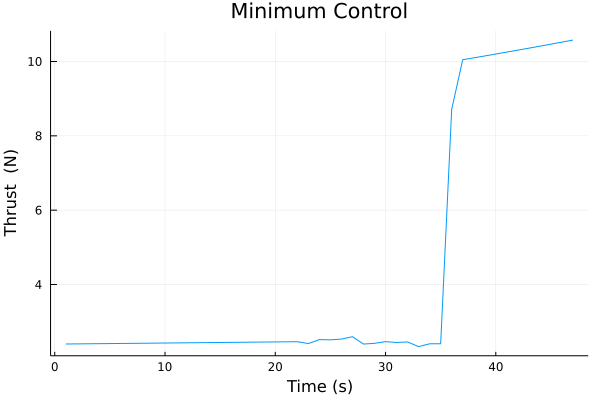

In [68]:
Plots.plot(xn,title="Minimum Control",xaxis="Time (s)", yaxis="Thrust  (N)",zaxis="z (m)", legend=false)

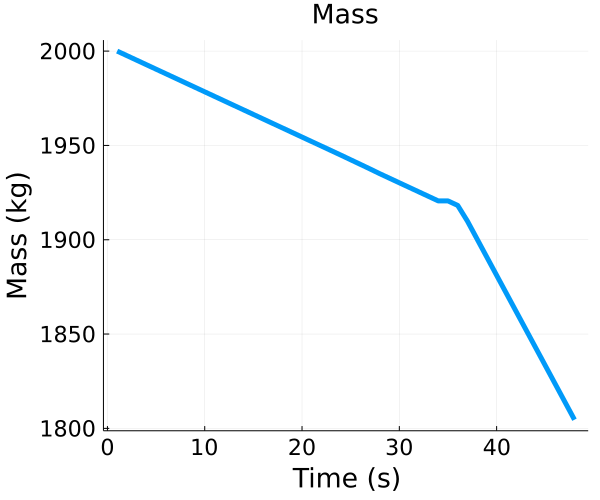

In [78]:
Plots.plot(exp.(optimal_x[7,:]),title="Mass",xaxis="Time (s)", yaxis="Mass (kg)",zaxis="z (m)", legend=false, 
xtickfontsize=15,ytickfontsize=15, legendfont=font(15), guidefont=font(18), titlefont = font(18), linewidth=5)

plot!(size=(600,500))

In [83]:
mass_used = exp.(optimal_x[7,1]) - exp.(optimal_x[7,end])

195.40305373608317

In [71]:
mass = exp.(optimal_x[7,:])

48-element Vector{Float64}:
 1999.9999999999998
 1997.601439518439
 1995.2028810124502
 1992.8043240970737
 1990.4057690292866
 1988.0072157956156
 1985.6086641109048
 1983.210114306533
 1980.8115662680511
 1978.4130201186142
 1976.0144759836385
 1973.6159339999458
 1971.2173936247948
    ⋮
 1909.8537282537673
 1900.284016759465
 1890.7144817135122
 1881.1451250881778
 1871.575948952415
 1862.0069553697012
 1852.4381463931811
 1842.8695241758762
 1833.3010908310364
 1823.732848590923
 1814.1647996264646
 1804.5969462639166

In [72]:
Thrust = optimal_u[1:3,:]

3×47 Matrix{Float64}:
 0.820848  0.821834  0.822822  0.823812  …  10.4634     10.5182    10.5736
 1.1783    1.41545   1.62859   1.8534        0.0959571   0.095759   0.0955564
 1.92295   1.75916   1.56791   1.29914      -0.192752   -0.193767  -0.194789

In [73]:
#re scale the thrust 
#N = 53
N = 48
N_thrust = zeros(3, N-1)

for i=1:N-1
    N_thrust[:,i] = Thrust[1:3,i].*mass[i]
end

In [74]:
norm_scaled = xn = [norm(x) for x in eachcol(N_thrust[1:3,:])]

47-element Vector{Float64}:
  4799.967405910307
  4799.884242336907
  4799.979636019175
  4799.936078834824
  4799.914458844549
  4799.964945380562
  4799.949893031024
  4799.990749347558
  4799.982989728358
  4799.972871470136
  4799.9565867412475
  4799.989222545391
  4799.946930108401
     ⋮
 16710.04940217867
 19187.534833586724
 19187.423195695552
 19187.310012688864
 19187.195257551994
 19187.078902476995
 19186.960918016684
 19186.841273000617
 19186.71993656421
 19186.596875305782
 19186.472057495936
 19186.34544782925

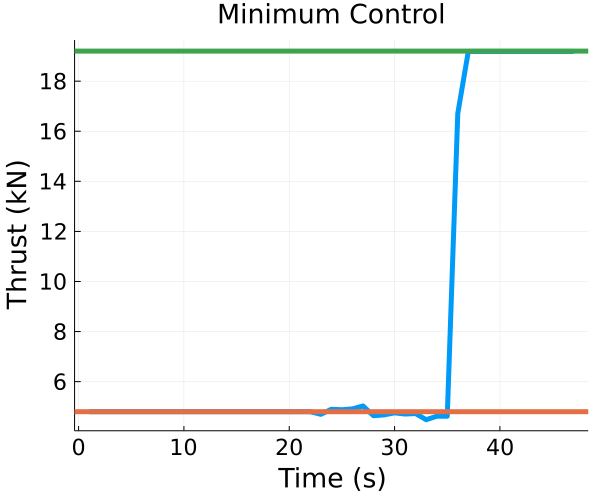

In [82]:
Plots.plot(norm_scaled/1000,title="Minimum Control",xaxis="Time (s)", yaxis="Thrust (kN)",zaxis="z (m)", legend=false, 
xtickfontsize=15,ytickfontsize=15, legendfont=font(15), guidefont=font(18), titlefont = font(18), linewidth=5)
#Plots.plot!(Vector[[4800,19200]], linetype=[:hline, :hline], widths=[10, 10])
Plots.plot!([4800/1000], linetype=:hline, width=5)
Plots.plot!([19200/1000], linetype=:hline, width=5)

plot!(size=(600,500))

In [31]:
optimal_x

7×48 Matrix{Float64}:
 2400.0     2388.55    2374.11    …   30.9978     13.8109     3.45973
  450.0      410.59     372.417        0.513315    0.227462   0.0566989
 -330.0     -319.038   -306.317       -0.918152   -0.408734  -0.102321
  -10.0      -12.9942   -15.982      -20.5909    -13.7829    -6.91946
  -40.0      -38.9021   -37.4879      -0.343729   -0.228128  -0.113552
   10.0       11.8558    13.6523  …    0.610653    0.408183   0.204641
    7.6009     7.5997     7.5985       7.50862     7.50336    7.49807